In [148]:
#!/usr/bin/env python3

%reload_ext autoreload
%autoreload 2

# Maths
import numpy as np

# PCovR utilities
from regression import LR, KRR, SparseKRR, PCovR, KPCovR, SparseKPCovR
from decomposition import PCA, KPCA, SparseKPCA
from kernels import linear_kernel, gaussian_kernel, center_kernel
from tools import FPS, split

# ASE
from ase.io import read, write

# SOAP
from rascal.representations import SphericalInvariants as SOAP

# Scikit learn
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Make the plots look nicer
plot_parameters = {
    'lines.linewidth': 1.0,
    'lines.markersize': 2,
    'patch.linewidth': 1.0,
    'hatch.linewidth': 1.0,
    'axes.linewidth': 1.0,
    'xtick.top': True,
    'xtick.bottom': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'xtick.major.size': 4.0,
    'xtick.minor.size': 2.0,
    'xtick.major.pad': 5.0,
    'xtick.minor.pad': 5.0,
    'ytick.left': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
    'ytick.major.size': 4.0,
    'ytick.minor.size': 2.0,
    'ytick.major.pad': 5.0,
    'ytick.minor.pad': 5.0   
}

for pp in plot_parameters.keys():
    mpl.rcParams[pp] = plot_parameters[pp]

In [149]:
# Read xyz files
s = read('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/KernelPCovR/datasets/CSD-1000R.xyz', index=':5')

# Extract chemical shifts
cs = []
for ss in s:
    ss.wrap()
    cs.append(ss.arrays['CS_local'])

In [150]:
# Compute SOAPs (from librascal tutorial)
soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=6,
           max_angular=6,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5)

In [151]:
soap_rep = soap.transform(s)

In [152]:
X = soap_rep.get_features(soap)

In [153]:
n_FPS = 200
idxs, d = FPS(X.T, n_FPS)
X = X[:, idxs]

In [297]:
# Center the data
Y = np.concatenate(cs)
X -= np.mean(X, axis=0)
Y -= np.mean(Y, axis=0)
print(X.shape)
print(Y.shape)

(720, 200)
(720,)


# TODO: add auto kernel centering to functions

# PCA

In [155]:
pca = PCA(n_pca=2)
pca.fit(X)
Xpca = pca.transform(X)

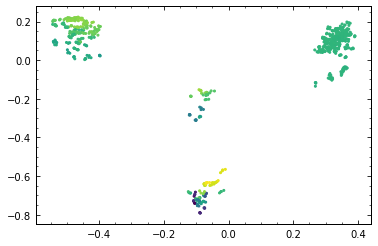

In [156]:
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=Y, cmap='viridis')

# Linear Regression

In [157]:
lr = LR()
lr.fit(X, Y)
Yplr = lr.transform(X)

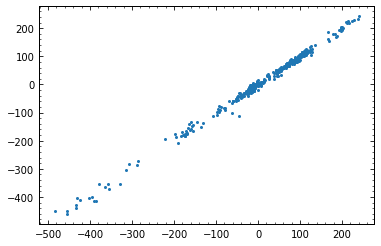

In [158]:
plt.scatter(Y, Yplr)
plt.show()

# KPCA

In [159]:
kpca = KPCA(n_kpca=2)
K = gaussian_kernel(X, X)
Kc = center_kernel(K)
kpca.fit(Kc)
Xkpca = kpca.transform(Kc)

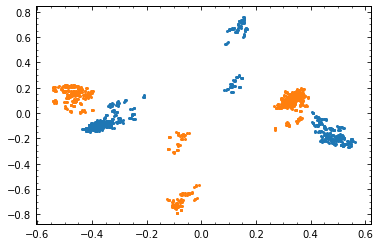

In [160]:
plt.scatter(Xkpca[:, 0], Xkpca[:, 1])
plt.scatter(Xpca[:, 0], Xpca[:, 1])
plt.show()

# KRR

In [266]:
krr = KRR()
krr.fit(K, Y)
Ypkrr = krr.transform(K)

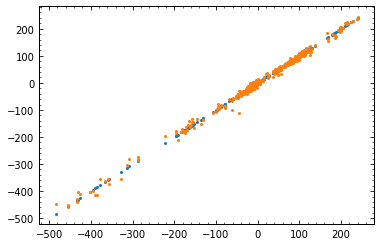

In [267]:
plt.scatter(Y, Ypkrr)
plt.scatter(Y, Yplr)
plt.show()

# Sparse KPCA

In [305]:
idxs, _ = FPS(X, 200)

In [306]:
# Centering kernels doesn't matter for sparse KPCA
Xs = X[idxs, :]
KNM = gaussian_kernel(X, Xs)
KMM = gaussian_kernel(Xs, Xs)

KMMc = center_kernel(KMM)
KNMc = center_kernel(KNM, K_ref=KMM)

In [307]:
kpca_sparse = SparseKPCA(n_kpca=2)
kpca_sparse.fit(KNMc, KMMc)
Xskpca = kpca_sparse.transform(KNMc)

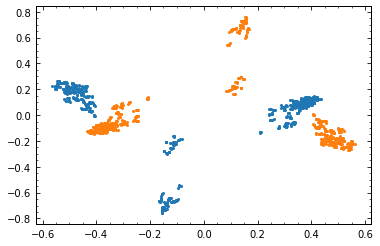

In [308]:
plt.scatter(Xskpca[:, 0], Xskpca[:, 1])
plt.scatter(Xkpca[:, 0], Xkpca[:, 1])
plt.show()

# Sparse KRR

In [309]:
skrr = SparseKRR(sigma=1E-5)
skrr.fit(KNM, KMM, Y)
Ypskrr = skrr.transform(KNM)

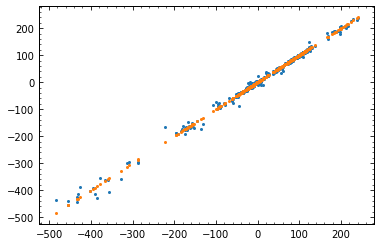

In [310]:
plt.scatter(Y, Ypskrr)
plt.scatter(Y, Ypkrr)
plt.show()

# PCovR

In [311]:
pcovr0 = PCovR(alpha=0.0, n_pca=None)
pcovr1 = PCovR(alpha=1.0, n_pca=None)

In [312]:
pcovr0.fit_structure_space(X, Y)
pcovr1.fit_structure_space(X, Y)

In [313]:
Xp, Xr = pcovr1.transform_X(X)
Yp = pcovr0.transform_Y(X)

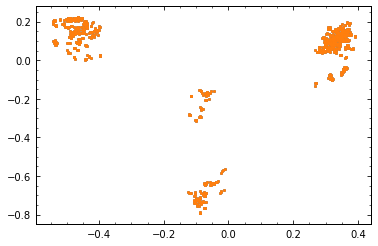

In [314]:
plt.scatter(Xp[:, 0], Xp[:, 1])
plt.scatter(Xpca[:, 0], Xpca[:, 1])
plt.show()

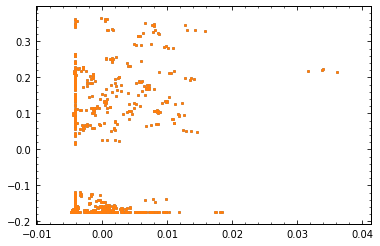

In [315]:
plt.scatter(Xr[:, 0], Xr[:, 1])
plt.scatter(X[:, 0], X[:, 1])
plt.show()

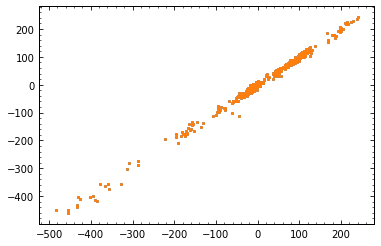

In [316]:
plt.scatter(Y, Yp)
plt.scatter(Y, Yplr)
plt.show()

# Kernel PCovR

In [317]:
kpcovr0 = KPCovR(alpha=0.0, n_kpca=None)
kpcovr1 = KPCovR(alpha=1.0, n_kpca=None)

In [318]:
kpcovr0.fit(Kc, Y)
kpcovr1.fit(Kc, Y)

In [319]:
Xkp, Xrkp = kpcovr1.transform_K(Kc)
Ykp = kpcovr0.transform_Y(Kc)

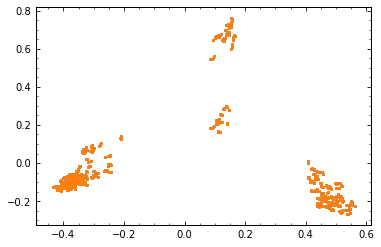

In [320]:
plt.scatter(Xkp[:, 0], Xkp[:, 1])
plt.scatter(Xkpca[:, 0], Xkpca[:, 1])
plt.show()

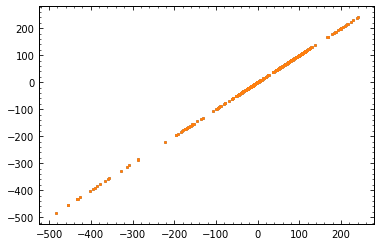

In [321]:
plt.scatter(Y, Ykp)
plt.scatter(Y, Ypkrr)
plt.show()

# Sparse KPCovR

In [322]:
skpcovr0 = SparseKPCovR(alpha=0.0, n_kpca=None, sigma=1E-5)
skpcovr1 = SparseKPCovR(alpha=1.0, n_kpca=None, sigma=1E-5)

In [323]:
skpcovr0.fit(KNM, KMM, Y)
skpcovr1.fit(KNM, KMM, Y)

In [324]:
Xskp, Xrskp = skpcovr1.transform_K(KNM)
Yskp = skpcovr0.transform_Y(KNM)

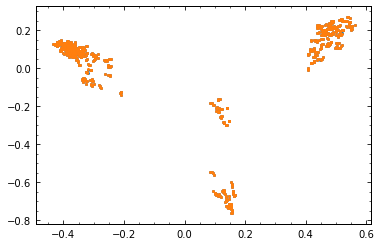

In [325]:
plt.scatter(Xskp[:, 0], Xskp[:, 1])
plt.scatter(Xkpca[:, 0], -Xkpca[:, 1])
plt.show()

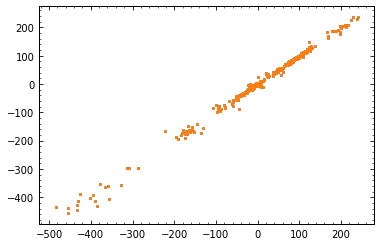

In [326]:
plt.scatter(Y, Yskp)
plt.scatter(Y, Ypskrr)
plt.show()